In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Download the codeSearchNetChallenge dataset 
_If needed_

In [2]:
%run downloading_cleaning_codeSearchNetChallenge_dataset.ipynb

CodeSearchNet challenge dataset ready to use!


## Exporting the codeSearchNetChallenge dataset to CSV files

_If needed_

In [3]:
%run preparing_csv_files_from_codeSearchNetChallenge_dataset.ipynb

Total lines of Python code in the dataset (after removing empty lines)
11206193


Total lines of Python code in the dataset's train folder (after removing empty lines)
10054266


Total lines of Python in the dataset's test folder (after removing empty lines)
541338


Total lines of Python in the dataset's valid folder
610589


## Training tokenizer using SentencePiece

_model_type=bpe_

In [4]:
import torch
print ('Current cuda device in use: ', torch.cuda.current_device())

Current cuda device in use:  0


In [5]:
from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece

In [6]:
vocab_size = 600
model_prefix = 'bpe_model'

In [7]:
codeSearchNet_challenge_path = './CodeSearchNet_challenge_dataset'
all_csv_path = './CodeSearchNet_challenge_dataset/CodeSearchNet_challenge_dataset.csv'
train_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/train/train_CodeSearchNet_challenge_dataset.csv'
test_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/test/test_CodeSearchNet_challenge_dataset.csv'
valid_csv_path = './CodeSearchNet_challenge_dataset/python/final/jsonl/valid/valid_CodeSearchNet_challenge_dataset.csv'

In [8]:
spm.SentencePieceTrainer.Train(f'--input={all_csv_path}'\
                               f' --model_prefix={model_prefix}'\
                               f' --vocab_size={vocab_size}'\
                               f' --model_type=bpe'\
                               f' --unk_piece={UNK} --bos_piece={BOS} --eos_id=-1 --pad_piece={PAD}')

In [9]:
## load up the Processor
sp = spm.SentencePieceProcessor()
sp.load(f'{model_prefix}.model')

True

In [10]:
itos = []
with open(f'{model_prefix}.vocab','r') as f:
    for line_num,line in enumerate(f):
        itos.append(line.split("\t")[0])

class SPTokenizer(BaseTokenizer):
    "Wrapper around a SentncePiece tokenizer to make it a `BaseTokenizer`."
    def __init__(self, model_prefix:str):
        self.tok = spm.SentencePieceProcessor()
        self.tok.load(f'{model_prefix}.model')

    def tokenizer(self, t:str) -> List[str]:
        return self.tok.EncodeAsPieces(t)
    
class CustomTokenizer():
    '''Wrapper for SentencePiece toeknizer to fit into Fast.ai V1'''
    def __init__(self,tok_func:Callable,model_prefix:str, pre_rules:ListRules=None):
        self.tok_func,self.model_prefix = tok_func,model_prefix
        self.pre_rules  = ifnone(pre_rules,  defaults.text_pre_rules )
        
    def __repr__(self) -> str:
        res = f'Tokenizer {self.tok_func.__name__} using `{self.model_prefix}` model with the following rules:\n'
        for rule in self.pre_rules: res += f' - {rule.__name__}\n'
        return res        

    def process_text(self, t:str,tok:BaseTokenizer) -> List[str]:
        "Processe one text `t` with tokenizer `tok`."
        for rule in self.pre_rules: t = rule(t)  
        toks = tok.tokenizer(t)
        #post rules?
        return toks 
    
    def _process_all_1(self,texts:Collection[str]) -> List[List[str]]:
        'Process a list of `texts` in one process'
        tok = self.tok_func(self.model_prefix)
        return [self.process_text(t,tok) for t in texts]
                                                                     
    def process_all(self, texts:Collection[str]) -> List[List[str]]: 
        "Process a list of `texts`."                                 
        return self._process_all_1(texts)


In [11]:
mycust_tok = CustomTokenizer(SPTokenizer, model_prefix)

In [12]:
#setup Vocab object for use in LM
sp_vocab = Vocab(itos)

In [13]:
data = TextLMDataBunch.from_csv('./', train_csv_path, test=test_csv_path, tokenizer=mycust_tok, vocab=sp_vocab)

/opt/tljh/user/lib/python3.7/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [14]:
data.show_batch()

/opt/tljh/user/lib/python3.7/site-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"er ▁l ine , ▁w r ite ▁e a ch ▁ro w ▁to ▁the ▁g iv en ▁in put ▁file ▁with ▁fi eld s ▁se par ated ▁by ▁t a b s . ▁: type ▁m ap F N H : ▁file ▁or ▁str ▁: param ▁m ap F N H : ▁E ith er ▁the ▁f ul l ▁path ▁to ▁the ▁m ap ▁file ▁or ▁an ▁o p en"
1,"t : b ro ca de - v c s ', ▁def in ing _ m od ule =' b ro ca de - v c s ', ▁y an g _ type =' r p c ', ▁is _ con fig = True ) """" "" , ▁ } ) ▁self ._ _ get _ v c s _ de ta il s ▁= ▁t ▁if ▁h as at"
2,"▁h as ▁the ▁s ame ▁time ▁s cal e ▁as ▁the ▁fi r st ▁ one ▁( t he ▁t w o ▁p lo ts ▁are ▁s y n ch r on iz ed ), ▁be ing ▁p lo t t ed ▁the ▁e v ol ut ion ▁time ▁se ri es ▁of ▁E M G ▁me di an ▁f re qu en c y . ▁P er ▁m us"
3,as ▁# ▁re mo v ed ▁in ▁the ▁a bo ve ▁c ode ▁f ra g ment ▁al read y . ▁key se qu en ce ▁= ▁key se qu en ce [ : - 1 ] ▁# ▁N ow ▁s u c cess iv el y ▁re mo ve ▁the ▁key ▁se qu en ce ▁in ▁re ver se ▁or der . ▁wh ile ( len ( key se
4,"s ▁to ▁s h ort ▁ch ar s . ▁"""" "" ▁out ▁= ▁'' ▁for ▁ch ar ▁in ▁ch ar s : ▁if ▁ch ar ▁in ▁_ c d . B I G 5 : ▁out ▁+ = ▁_ c d . G B K [ _ c d . B I G 5 . in dex ( ch ar ) ] ▁else : ▁out ▁+ = ▁ch ar ▁return"


In [15]:
data.save('20200811_bpe_model_databunch_data_save.pkl') 

In [16]:
data = load_data('./', '20200811_bpe_model_databunch_data_save.pkl', bs=1600)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


In [17]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

In [18]:
print(learn.model)

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(600, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(600, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=600, bias=True)
    (output_dp): RNNDropout()
  )
)


In [19]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 5.75E-02
Min loss divided by 10: 1.58E-01


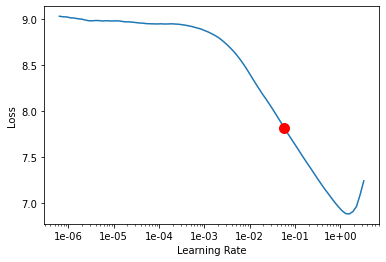

In [21]:
learn.recorder.plot(suggestion=True)

In [22]:
learn.fit_one_cycle(1, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,3.328326,3.122928,0.314351,19:42


In [23]:
learn.save('20200811_fit_head_bpe_model_drop_mult')

In [24]:
learn.load('20200811_fit_head_bpe_model_drop_mult');

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(30, slice(1e-1, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.928001,1.996182,0.520855,28:57
1,1.850428,1.950834,0.529625,29:05
2,1.874266,1.978287,0.523630,29:13
3,1.936947,2.023138,0.516128,29:06
4,1.962458,2.054753,0.510439,28:56
5,1.975345,2.080720,0.505472,28:47
6,1.999894,2.081296,0.505816,28:37
7,1.983418,2.079545,0.506184,28:32
8,1.963275,2.058214,0.510210,28:34
9,1.936085,2.029901,0.515913,28:35


In [29]:
learn.save('20200811_fine_tuned_bpe_model_drop_mult')

In [30]:
learn.load('20200811_fine_tuned_bpe_model_drop_mult');

In [31]:
TEXT = "import from"
N_WORDS = 25
N_SENTENCES = 3
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

import from the XML and AppList to the given implementation. item_
import from XXX modules = [] return [impl.set_import(map
import from create_packages on XML registry XMLPackage.


In [32]:
print(learn.summary())

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 600]            240,600    True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 240,600
Total trainable params: 240,600
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function

In [33]:
TEXT = "from pandas import"
N_WORDS = 25
N_SENTENCES = 5
for _ in range(N_SENTENCES):
    predicted = learn.predict(TEXT, N_WORDS, temperature=0.9)
    val = predicted.replace(TEXT, '')
    decoded = sp.decode_pieces(val.split())
    print(TEXT + " "+  decoded)

from pandas import parse_xyz from sqlalchemy.orm.elements.types i
from pandas import DataFrame import io class FindHierarchy(str): run
from pandas import iterer as gps_procs import numpy as np data = np.ren
from pandas import TranslationLogic instances = [HT_LIST_VAL
from pandas import PandasPandas # Convert to XSD for reading. input_in
